In [1]:
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
def resample(Nsamples, samples, weights):
    """Generate *Nsamples* samples from an empirical distribution defined by *samples* and *weights*

    Inputs
    ------
    Nsamples: integer, number of samples to generate
    samples: (N, d) array of N samples of dimension d that form the empirical distribution
    weights: (N, ) array of N weights

    Returns
    --------
    samples_out: (Nsamples, d) new samples
    weights_out: (Nsamples, ) new weights equal to 1 / N
    """

    N = weights.shape[0]  # get number of points that make up the empirical distribution
    
    # Randomly choose the integers (with replacement) between 0 to N-1 with probabilities given by the weights
    samp_inds = np.random.choice(np.arange(N), Nsamples, p=weights)

    # subselect the samples chosen
    samples_out = samples[samp_inds, :]

    # return uniform weights
    weights_out = np.ones((Nsamples))/Nsamples
    return samples_out, weights_out

In [3]:
def compute_mean_std(samples, weights):
    """Compute the mean and standard deviation of multiple empirical distirbution.

    Inputs
    ------
    samples: (N, d, m) array of samples defining the empirical distribution
    weights: (N, m) array of weights

    Returns
    -------
    means: (m, d) array of means
    stds: (m, d) array of standard deviations

    Notes
    -----
    m is the number of empirical distributions
    """

    N, d, m = samples.shape
    means = np.zeros((m, d))
    stds = np.zeros((m, d))
    for ii in range(m):
        means[ii, :] = np.dot(weights[:, ii], samples[:, :, ii])
        stds[ii, :] = np.sqrt(np.dot(weights[:, ii], (samples[:, :, ii] - np.tile(means[ii, :], (N, 1)))**2))
    return means, stds

In [4]:
data_vocv = pd.read_csv('VOCV_SOC_map.csv')
SoC_arr_vocv = np.array(data_vocv['time'])
V_arr_vocv = np.array(data_vocv[' V'])
# create a unifrom time vector

def V_OCV(SoC, dt, Nsims):

    time_uniform = np.arange(0, Nsims*dt, dt)

    # interpolate voltage
    v_interpolated = np.interp(time_uniform, SoC_arr_vocv, V_arr_vocv)

    closest_index = (np.abs(time_uniform - SoC)).argmin()

    return v_interpolated[closest_index]

def current_user(t, params):

    R_CT, tau_CT, R_dif, tau_dif, dt, Q_nom, R0, Nsims = params

    time = t*dt
    if time%2>0 and time%2<0.2:
        return 25
    elif time%2>0.2 and time%2<1:
        return 18
    elif time%2>1 and time<1.8:
        return 8
    elif time%2>1.8 and time%2<2:
        return 0
    else:
        return 0

In [5]:
def battery_dynamics(state, current, n_states, params):

    """Battery dynamics

    Inputs
    ------
    state : either (2,) or (N, 2) for vectorized input
    """
    R_CT, tau_CT, R_dif, tau_dif, dt, Q_nom, R0, Nsims = params
    if state.ndim == 1:
        next_state = np.zeros((n_states))
        next_state[0] = state[0] - (dt/Q_nom)*current
        next_state[1] = np.exp(-dt / tau_CT) * state[1] + R_CT * (1 - np.exp(-dt / tau_CT)) * current
        next_state[2] = np.exp(-dt / tau_dif) * state[2] + R_dif * (1 - np.exp(-dt / tau_dif)) * current

    else: # multiple inputs
        next_state = np.zeros(state.shape)
        next_state[:, 0] = state[:, 0] - np.ones_like(state[:, 0])*(dt/Q_nom)*current
        next_state[:, 1] = np.exp(-dt / tau_CT) * state[:, 1] + R_CT * (1 - np.exp(-dt / tau_CT)) * current * np.ones_like(state[:, 1])
        next_state[:, 2] = np.exp(-dt / tau_dif) * state[:, 2] + R_dif * (1 - np.exp(-dt / tau_dif)) * current * np.ones_like(state[:, 2])
    return next_state

def observe(state, current, params):

    if state.ndim == 1:
        out = np.zeros((1))
        SoC, V_CT, V_dif = state
        R_CT, tau_CT, R_dif, tau_dif, dt, Q_nom, R0, Nsims = params
        VOCV = V_OCV(SoC, dt, Nsims)
        V = VOCV - R0*current - V_CT - V_dif
        out[0] = V
    else:
        out = np.zeros((state.shape[0], 1))
        for ii in range(state.shape[0]):
            SoC, V_CT, V_dif = state[ii, :]
            R_CT, tau_CT, R_dif, tau_dif, dt, Q_nom, R0, Nsims = params
            VOCV = V_OCV(SoC, dt, Nsims)
            V = VOCV - R0*current - V_CT - V_dif
            out[ii, 0] = V
        #out[:, 0] = np.sin(state[:, 0])
    return out

In [6]:
def step(current, n_states, params, prop, proppdf, current_samples, current_weights, likelihood, data, propagator, dt, Lproc, proc_var, proc_mat_inv, noise_var):
    """
    Propagate a particle filter

    Inputs
    --------
    prop            - proposal function (current_state, data)
    proppdf         - proposal function logpdf
    current_samples - ensemble of samples
    current_weights - ensemble of weights
    likelihood      - function to evaluate the log likelihood (samples, data)
    data            - Observation
    propagator      - dynamics logpdf

    @returns samples and weights after assimilating the data
    """

    new_samples = prop(current_samples, current, n_states, params, data, Lproc)
    new_weights = likelihood(new_samples, current, params, data, noise_var) + propagator(new_samples, current_samples, current, n_states, params, data, proc_var, proc_mat_inv) - \
                            proppdf(new_samples, current_samples, current, n_states, params, data, proc_var, proc_mat_inv)
    
    log_weights = new_weights + np.log(current_weights)
    max_log_weight = np.max(log_weights)
    log_weights -= max_log_weight 
    weights = np.exp(log_weights)
    new_weights = weights / np.sum(weights)
    
    return new_samples, new_weights

In [7]:
def particle_filter(data, prior_mean, prior_cov,
                    prop, proppdf, likelihood, propagator, dt, Lproc, proc_var, proc_mat_inv, noise_var,
                    time_instances_to_store, params, n_states, return_sample_memory=True, nsamples=1000, resampling_threshold_frac=0.1):
    
    """Particle Filter

    Inputs
    -------
    data: (nsteps, m) array of data points, N is the time index, m is the dimensionality of the data
    prior_mean: (d), prior mean
    prior_cov: (d, d), prior mean
    Nsamples: integer, number of samples in the empirical distribution
    resampling_threshold_frac: float between 0 and 1 indicating to resample when effective sample size below frac of nsamples

    Returns
    -------
    samples: (nsamples, d, nsteps)
    weights: (nsamples, nsteps)
    eff: (nsamples), effective sample size

    Notes
    -----
    For documentation of prop, proppdf, likelihood, and propagator -- see the step function
    """
    
    d = prior_mean.shape[0]
    nsteps = data.shape[0]

    # create a sample memory array for storage
    sample_memory = []
    weight_memory = []

    # Allocate memory
    samples = np.zeros((nsamples, d, nsteps+1))
    weights = np.zeros((nsamples, nsteps+1))
    eff = np.zeros((nsteps+1)) # keep track of effective sample size at each step


    # Generate initial samples from the prior
    L = np.linalg.cholesky(prior_cov)
    samples[:, :, 0] = np.tile(prior_mean, (nsamples, 1))+ np.dot(L, np.random.randn(d, nsamples)).T
    weights[:, 0] = 1.0 / nsamples # all weights are equal because of independent sampling from prior
    eff[0] = nsamples

    resamp_threshold = int(nsamples * resampling_threshold_frac)

    for ii in range(1, nsteps+1):
        current_step = current_user(ii, params)
        samples[:, :, ii], weights[:, ii] = step(current_step, n_states, params, prop, proppdf, samples[:, :, ii-1], weights[:, ii-1],
                                                 likelihood, data[ii-1, :], propagator, dt, Lproc, proc_var, proc_mat_inv, noise_var)

        #weights[:, ii] = normalise(weights[:, ii])

        # compute the effective sample size
        eff[ii] = 1.0 / np.sum(weights[:, ii]**2)

        if ii % 50 == 0:
            print("eff = ", ii, eff[ii])

        # resample if effective sample size is below threshold
        if eff[ii] < resamp_threshold:
            samples[:, :, ii], weights[:, ii] = resample(nsamples, samples[:, :, ii], weights[:, ii])
        
        if ii in time_instances_to_store:
            sample_memory.append(samples[:, :, ii])
            weight_memory.append(weights[:, ii])
   
    if return_sample_memory:
        return samples, weights, eff, sample_memory, weight_memory
    else:
        return samples, weights, eff

In [8]:
def proposal(current_state, current, n_states, params, data, Lproc):
    """ Bootstrap Particle Filter the proposal is the dynamics!"""

    R_CT, tau_CT, R_dif, tau_dif, dt, Q_nom, R0, Nsims = params

    if current_state.ndim == 1:
        return battery_dynamics(current_state, current, n_states, params) + np.dot(Lproc, np.random.randn(n_states))
    else:
        nsamples = current_state.shape[0]
        return battery_dynamics(current_state, current, n_states, params) + np.dot(Lproc, np.random.randn(n_states, nsamples)).T

def proposal_logpdf(current, previous, current_ampere, n_states, params, data, proc_var, proc_mat_inv):
    """ Bootstrap Particle Filter: the proposal is the dynamics"""
    nexts  = battery_dynamics(previous, current_ampere, n_states, params)
    delta = nexts - current
    if current.ndim == 1:
        return -0.5 * np.dot(delta, np.dot(proc_mat_inv, delta))
    else:
        return -0.5 * np.sum(delta * np.dot(delta, proc_mat_inv.T), axis=1)

def likelihood(state, current, params, data, noise_var):
    """Gaussian Likelihood through nonlinear model"""
    dpropose = observe(state, current, params)
    delta = dpropose - data
    if state.ndim == 1:
        return -0.5 * np.dot(delta, delta) / noise_var
    else:
        return -0.5 * np.sum(delta * delta, axis=1) / noise_var

eff =  50 8562.331068041305
eff =  100 6645.962878004525
eff =  150 5569.455477632224
eff =  50 7616.052498328482
eff =  100 3597.3820154371115
eff =  150 6857.419108276224


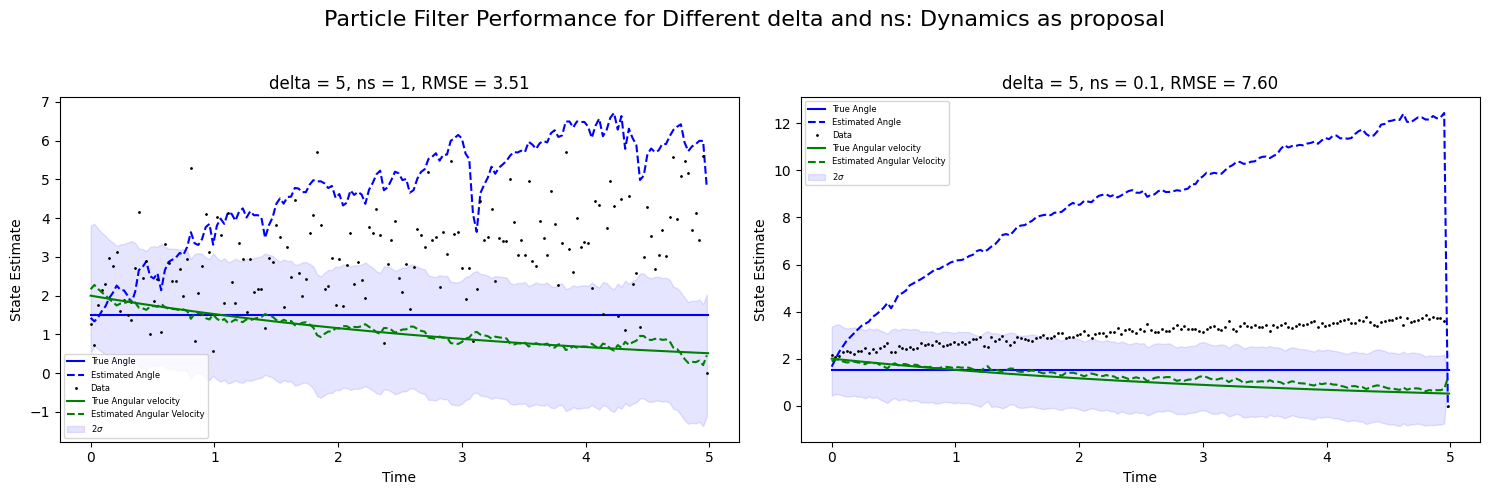

In [9]:
## Combined Analysis

# Parameters
x0 = np.array([1.5, 2, 0])  # Initial state 
dt = 0.01  # Time step
Nsteps = 500  # Number of time steps
times = np.arange(0, Nsteps*dt, dt)  # Time array
num_samples = 10000  # Number of particles
resample_thresh = 0.5  # Resampling threshold
proc_var = 0.5  # Process noise variance
n_states = 3

# parameters for battery dynamics
R_CT, tau_CT, R_dif, tau_dif, Q_nom, R0 = 1.6*10**-3, 3.68, 7.7*10**-3, 84.34, 10.4, 6*10**-3
params_pf = [R_CT, tau_CT, R_dif, tau_dif, dt, Q_nom, R0, Nsteps]

tfinal_vocv = Nsteps*dt
time_uniform_vocv = np.arange(0, tfinal_vocv, dt)

# Initialize process noise covariance matrix
covval = 8.432 * 10**-4
proc_mat = np.zeros((3, 3))
proc_mat[0, 0] = 1000*covval
proc_mat[1, 1] = 10*covval
proc_mat[2, 2] = 1*covval

#proc_mat[0, 0] = proc_var / 3.0 * dt**3
#proc_mat[0, 1] = proc_var / 2.0 * dt**2
#proc_mat[1, 0] = proc_var / 2.0 * dt**2
#proc_mat[1, 1] = proc_var * dt

proc_mat_inv = np.linalg.pinv(proc_mat)
Lproc = np.linalg.cholesky(proc_mat)

# create array to store samples
sample_memories = []
weight_memories = []
time_instances_to_store = np.array([60, 140, 220, 300, 380])
return_sample_memory = False


# Combinations of delta and ns
delta_values = [3]
ns_values = [1, 0.1]

# Prepare the plot
if len(delta_values) == 1 and len(ns_values) == 1:
    fig, axs = plt.subplots(1, 1, figsize=(6, 5))
    fig.suptitle("Particle Filter Performance", fontsize=16)
else:
    fig, axs = plt.subplots(len(delta_values), len(ns_values), figsize=(15, 5))
    fig.suptitle("Particle Filter Performance for Different delta and ns: Dynamics as proposal", fontsize=16)

# Loop over delta and ns
for i, delta in enumerate(delta_values):
    for j, ns in enumerate(ns_values):
        noise_var = ns * ns  # Variance of observation noise
        obs_ind = np.arange(0, Nsteps, delta)  # Observation indices
        data = np.zeros((len(obs_ind), 1))  # Observed data

        # Generate truth and observations
        true = np.zeros((Nsteps, n_states))
        true[0, :] = x0
        obs_counter = 0

        for ii in range(1, Nsteps):
            
            # Generate current
            currenti = current_user(i, params_pf)

            true[ii, :] = battery_dynamics(true[ii-1, :], currenti, n_states, params_pf)
            if ii in obs_ind:
                data[obs_counter] = observe(true[ii, :], currenti, params_pf) + np.random.randn() * ns
                obs_counter += 1

        # Run particle filter
        if return_sample_memory == False:
            samples, weights, eff = particle_filter(
            data, true[0, :], np.eye(n_states), proposal, proposal_logpdf,
            likelihood, proposal_logpdf, dt, Lproc, proc_var, proc_mat_inv,
            noise_var, time_instances_to_store, params_pf, n_states, return_sample_memory, nsamples=num_samples, resampling_threshold_frac=resample_thresh)
        else:
            samples, weights, eff, sample_memory, weight_memory = particle_filter(
            data, true[0, :], np.eye(n_states), proposal, proposal_logpdf,
            likelihood, proposal_logpdf, dt, Lproc, proc_var, proc_mat_inv,
            noise_var, time_instances_to_store, return_sample_memory,nsamples=num_samples, resampling_threshold_frac=resample_thresh)

            sample_memories.append(sample_memory)
            weight_memories.append(weight_memory)

        means, stds = compute_mean_std(samples, weights)

        # Compute RMSE
        RMSE = np.sqrt(np.mean((means[1:, 0] - true[obs_ind, 0])**2))

        if len(delta_values) == 1 and len(ns_values) == 1:
            axs.plot(times, true[:, 0], 'b-', label='True Angle')
            axs.plot(times[obs_ind], means[1:, 0], 'b--', label='Estimated Angle')
            axs.plot(times[obs_ind], data[:, 0], 'ko', ms=1, label='Data')
            axs.fill_between(times[obs_ind],
                        means[1:, 0] - 2 * stds[1:, 0],
                        means[1:, 0] + 2 * stds[1:, 0],
                        color='blue', alpha=0.1)
            
            axs.plot(times, true[:, 1], 'g-', label='True Angular velocity')
            axs.plot(times[obs_ind], means[1:, 1], 'g--', label='Estimated Angular Velocity')
            #axs.fill_between(times[obs_ind],
            #            means[1:, 1] - 2 * stds[1:, 1],
            #            means[1:, 1] + 2 * stds[1:, 1],
            #            color='blue', alpha=0.1, label=r'$2\sigma$')
            
            axs.set_title(f"delta = {5}, ns = {ns}, RMSE = {RMSE:.2f}")
            axs.set_xlabel("Time")
            axs.set_ylabel("State Estimate")
            axs.legend(fontsize=6)

        elif len(delta_values) == 1 and len(ns_values) > 1:
            # Plot results
            ax = axs[j]
            ax.plot(times, true[:, 0], 'b-', label='True Angle')
            ax.plot(times[obs_ind], means[1:, 0], 'b--', label='Estimated Angle')
            ax.plot(times[obs_ind], data[:, 0], 'ko', ms=1, label='Data')
            #ax.fill_between(times[obs_ind],
            #            means[1:, 0] - 2 * stds[1:, 0],
            #            means[1:, 0] + 2 * stds[1:, 0],
            #            color='blue', alpha=0.1)
            
            ax.plot(times, true[:, 1], 'g-', label='True Angular velocity')
            ax.plot(times[obs_ind], means[1:, 1], 'g--', label='Estimated Angular Velocity')
            ax.fill_between(times[obs_ind],
                        means[1:, 1] - 2 * stds[1:, 1],
                        means[1:, 1] + 2 * stds[1:, 1],
                        color='blue', alpha=0.1, label=r'$2\sigma$')

            ax.set_title(f"delta = {5}, ns = {ns}, RMSE = {RMSE:.2f}")
            ax.set_xlabel("Time")
            ax.set_ylabel("State Estimate")
            ax.legend(fontsize=6)

        else:
            # Plot results
            ax = axs[i, j]
            ax.plot(times, true[:, 0], 'b-', label='True Angle')
            ax.plot(times[obs_ind], means[1:, 0], 'b--',  label='Estimated Angle')
            ax.plot(times[obs_ind], data[:, 0], 'ko', ms=1, label='Data')
            #ax.fill_between(times[obs_ind],
            #            means[1:, 0] - 2 * stds[1:, 0],
            #            means[1:, 0] + 2 * stds[1:, 0],
            #            color='blue', alpha=0.1)

            ax.plot(times, true[:, 1], 'g-', label='True Angular velocity')
            ax.plot(times[obs_ind], means[1:, 1], 'g--', label='Estimated Angular Velocity')
            ax.fill_between(times[obs_ind],
                        means[1:, 1] - 2 * stds[1:, 1],
                        means[1:, 1] + 2 * stds[1:, 1],
                        color='blue', alpha=0.1, label=r'$2\sigma$')

            ax.set_title(f"delta = {delta}, ns = {ns}, RMSE = {RMSE:.2f}")
            ax.set_xlabel("Time")
            ax.set_ylabel("State Estimate")
            ax.legend(fontsize=6)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()                                                                                                                                                  